In [58]:
import numpy as np
from time import time

import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from src.synthetic_data import DataGenerator
from src.gabp_mrf import run_GaBP
from src.visualization import set_plot_options, get_plot_colors, NetworkxGraph, AnalyzeResult
from src.utils import HiddenPrints

In [29]:
set_plot_options()
colors = get_plot_colors()

data_gen = DataGenerator()
result_analyzer = AnalyzeResult()

# Solving the system with non-symmetric matrix

In [49]:
num_nodes = 500
A, b = data_gen.get_sparse_tree_matrix(dim=num_nodes)

print(f'The data matrix A with shape of: {A.shape}')
print(f'The observation vector b with shape of: {b.shape}')

The data matrix A with shape of: (500, 500)
The observation vector b with shape of: (500,)


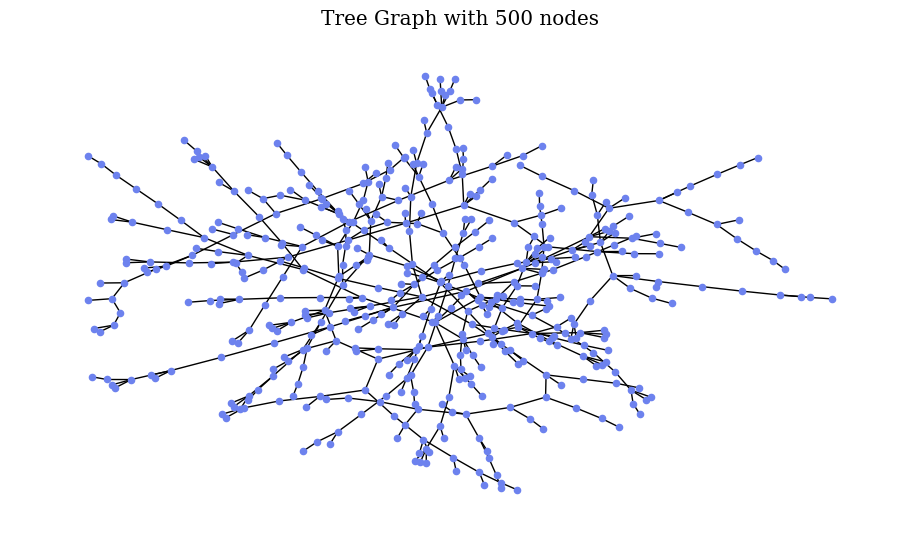

In [50]:
graph = NetworkxGraph(A)
graph.draw_graph(title=f'Tree Graph with {num_nodes} nodes', color=colors[0])

In [65]:
print('=> Running GaBP on the graph')
start_time = time()

P_i, mu_i, N_i, P_ii, mu_ii, P_ij, mu_ij, iter_dist = run_GaBP(A, b, max_iter=100, convergence_threshold=1e-5)

end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

=> Running GaBP on the graph
=> Converged after iteration 21
=> Running Time: 78.03[ms]


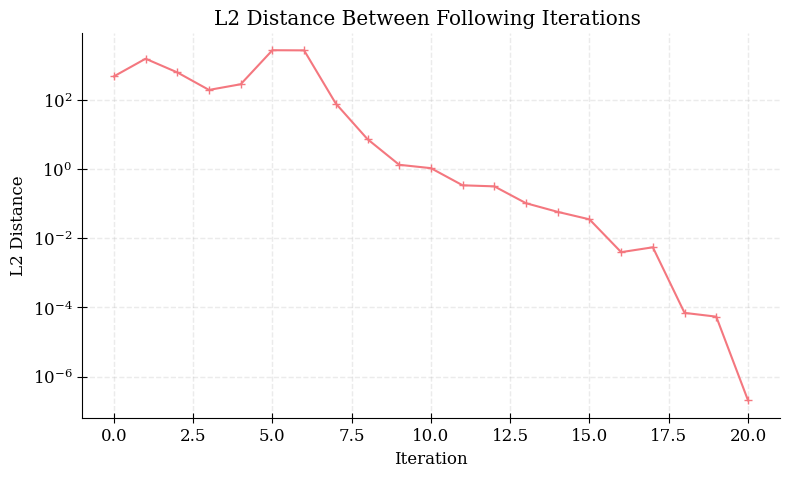

In [66]:
result_analyzer.plot_gabp_convergence(iter_dist, color=colors[3])

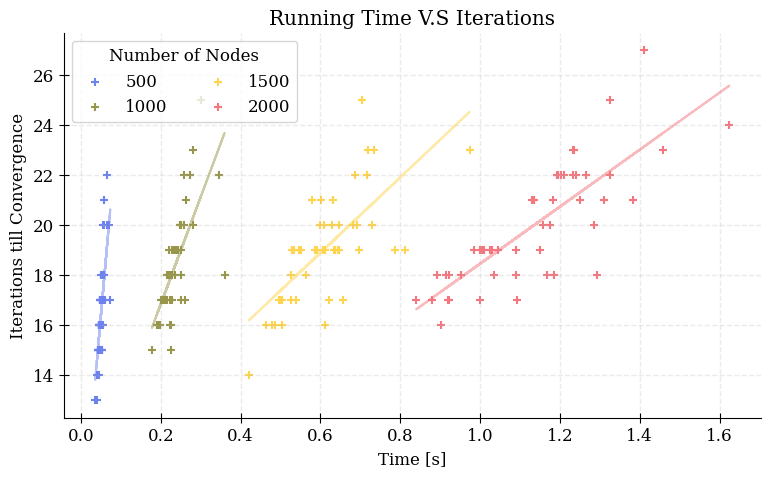

In [75]:
result_analyzer.plot_time_vs_iterations(num_iters=50, dims=[500, 1000, 1500, 2000])

# Comparing with other methods

LU can work faster, but it suffers if the values on the diagonal are very small even after a permutation

In [67]:
from scipy.linalg import lu_factor, lu_solve
start_time = time()
lu, piv = lu_factor(A)
x = lu_solve((lu, piv), b)
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')
# np.allclose(A @ x - b, np.zeros((4,)))

=> Running Time: 3.00[ms]


GMRES may work faster with restarts than GaBP. However, if we are solving for non-positively defined matrices this method may suffer from stagnation in convergence, as the restarted subspace is often close to an earlier subspace.

In [89]:
from scipy.sparse.linalg import gmres
start_time = time()
x, exitCode = gmres(A, b)
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

=> Running Time: 2468.00[ms]


In [69]:
from scipy.sparse.linalg import gmres
start_time = time()
x, exitCode = gmres(A, b, restart=num_nodes)
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

=> Running Time: 25.00[ms]


BiCGSTAB may also be a more appropriate choice. Since it can be viewed as a combination of BiCG and GMRES, where each BiCG step is followed by a GMRES(1) step it solves the convergence problem for GMRES for non-positively defined matrices and also smooths the convergence for BICG. However, due to the use of minimum residue polynomials of degree one, this correction may not be effective if the matrix A has large complex eigenpairs. 

In [73]:
start_time = time()
sol2 = scipy.sparse.linalg.bicg(A, b, x0=np.zeros(A.shape[0]))
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')


=> Running Time: 61.01[ms]


In [74]:
start_time = time()
sol2 = scipy.sparse.linalg.bicgstab(A, b, x0=np.zeros(A.shape[0]))
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

=> Running Time: 109.99[ms]


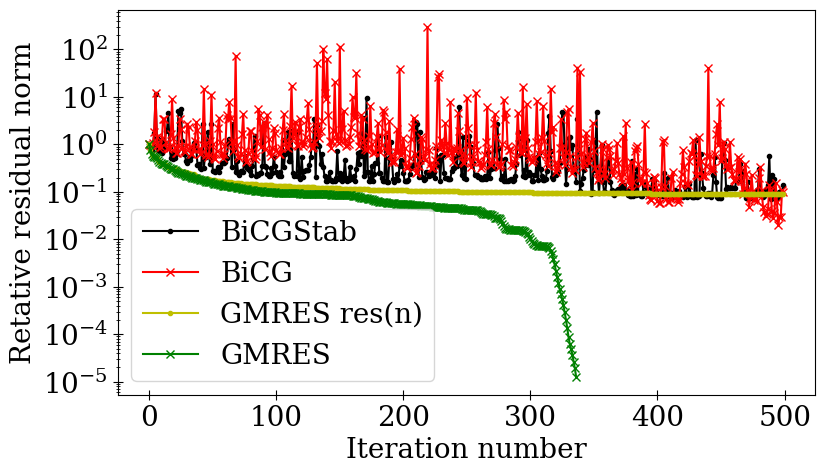

In [70]:
res_all_bicg = []
res_all_bicgstab = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - b))

def bicgstab_cl(x):
    res_all_bicgstab.append(np.linalg.norm(A.dot(x) - b))

res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r))
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r))

sol2 = scipy.sparse.linalg.gmres(A, b, restart=20, callback=gmres_rst_cl)
sol2 = scipy.sparse.linalg.gmres(A, b, restart=num_nodes, callback=gmres_rst)

    
sol2 = scipy.sparse.linalg.bicg(A, b, x0=np.zeros(A.shape[0]), callback=bicg_cl)
sol2 = scipy.sparse.linalg.bicgstab(A, b, x0=np.zeros(A.shape[0]), callback=bicgstab_cl)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]
res_all_bicgstab = np.array(res_all_bicgstab)/res_all_bicgstab[0]
res_gmres_rst = np.array(res_gmres_rst)/res_gmres_rst[0]
res_gmres = np.array(res_gmres)/res_gmres[0]

lim = 500
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')
plt.semilogy(res_gmres_rst[:lim], marker='.',color='y', label='GMRES res(n)')
plt.semilogy(res_gmres[:lim], marker='x',color='g', label='GMRES')

plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Retative residual norm', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

Although the Gaussian-Seidel method converges approximately like GaBP it has significant disadvantages such as complex conditions for convergence, but this method is well suited to sparse matrices

=> Running Time: 99.00[ms]


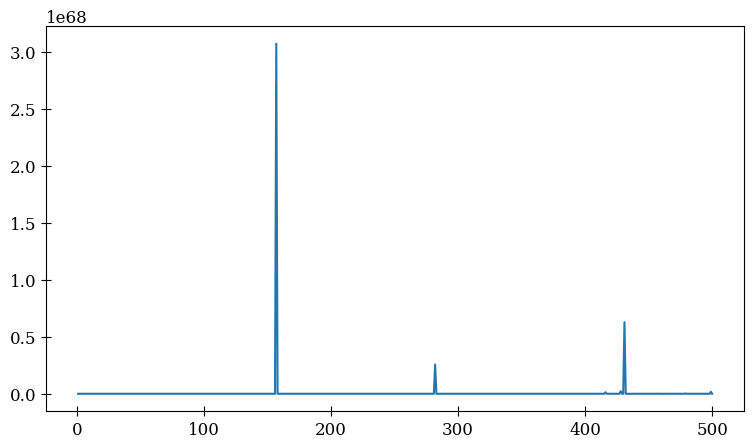

In [84]:
def seidel(a, x ,b): 
    norm = []
    
    n = len(a)                   
    for j in range(0, n):        
        d = b[j]                  
        for i in range(0, n):     
            if(j != i):
                d-=a[j][i] * x[i] 
        x_old = x.copy()
        x[j] = d / a[j][j]       
        norm.append(np.linalg.norm(x-x_old))
    return x, norm

start_time = time()
x, norm = seidel(A, b, b)
end_time = time()
dt = (end_time - start_time)*1000
print(f'=> Running Time: {dt :0.2f}[ms]')

plt.plot(list(range(1, len(x)+1)), norm)